In [1]:
# Import libraries

from datetime import datetime, timedelta
import warnings
import statsmodels.api as sm
import itertools
import seaborn as sns   
import os
from dateutil.parser import parse

# Numerical Analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import seaborn as sns
%matplotlib inline

# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.regression.linear_model import OLS


# Load the data into a pandas dataframe. 
# This can be a csv file or you can choose to connect to a datasource of your choice
df = pd.read_csv('signups and spend GAC.csv')

# Convert the date column to a datetime object
df['date'] = pd.to_datetime(df['date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     773 non-null    datetime64[ns]
 1   spend    773 non-null    float64       
 2   signups  773 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 18.2 KB


In [2]:
#check the start of the dataset
print(df.head())

#check the end of the dataset
print(df.tail())

        date        spend  signups
0 2021-01-01  5158.107971     5198
1 2021-01-02  6208.208169     6379
2 2021-01-03  8036.899649     7592
3 2021-01-04  4295.308506     3782
4 2021-01-05  3808.479745     3282
          date        spend  signups
768 2023-02-08  1548.226456     1776
769 2023-02-09  1551.105110     1735
770 2023-02-10  1865.782128     1880
771 2023-02-11  2338.652185     2490
772 2023-02-12  3619.207553     3847


In [3]:
# Remove outliers from the dataset
# Calculate the Z-score of each value in the data columns you are working with

z = np.abs(df['signups'] - df['signups'].mean()) / df['signups'].std()

df['z_score'] = z

df.head()

,date,spend,signups,z_score
0,2021-01-01,5158.107971,5198,0.040047
1,2021-01-02,6208.208169,6379,0.409698
2,2021-01-03,8036.899649,7592,0.789364
3,2021-01-04,4295.308506,3782,0.403158
4,2021-01-05,3808.479745,3282,0.559657


In [4]:
# Remove any rows which are more than 3 standard deviations away from the mean
df = df[z < 3]

In [5]:
# Set the date column as the index of the dataframe and the frequency as daily/weekly/monthly
df = df.set_index('date').asfreq('d')

# Sort the data by the index in ascending order
df = df.sort_index()

In [6]:
# Check if removed dates have been added back in (compare to first df.index above)
print(df.index)

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2023-02-03', '2023-02-04', '2023-02-05', '2023-02-06',
               '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10',
               '2023-02-11', '2023-02-12'],
              dtype='datetime64[ns]', name='date', length=773, freq='D')


In [7]:
# Check which rows have null values since being added back in to the dataframe

np.isfinite(df['signups'])

df[df.index.isin(np.isfinite(df[['signups']]).query('not signups').index)]

,spend,signups,z_score
date,,,
2021-04-04,NaN,NaN,NaN
2021-04-05,NaN,NaN,NaN
2021-04-25,NaN,NaN,NaN
2021-05-01,NaN,NaN,NaN
2021-05-02,NaN,NaN,NaN
2022-07-24,NaN,NaN,NaN
2022-07-31,NaN,NaN,NaN
2022-08-07,NaN,NaN,NaN


In [8]:
# Fill in the blanks with the median values of the dataset

df[['signups', 'spend']] = df[['signups', 'spend']].fillna(df[['signups', 'spend']].mean())


# Reset the date index in order to be able to work with the date column for the next charts
df = df.reset_index()

# Remove the z score column
df = df.drop(columns=["z_score"])

df.head()

,date,spend,signups
0,2021-01-01,5158.107971,5198.0
1,2021-01-02,6208.208169,6379.0
2,2021-01-03,8036.899649,7592.0
3,2021-01-04,4295.308506,3782.0
4,2021-01-05,3808.479745,3282.0


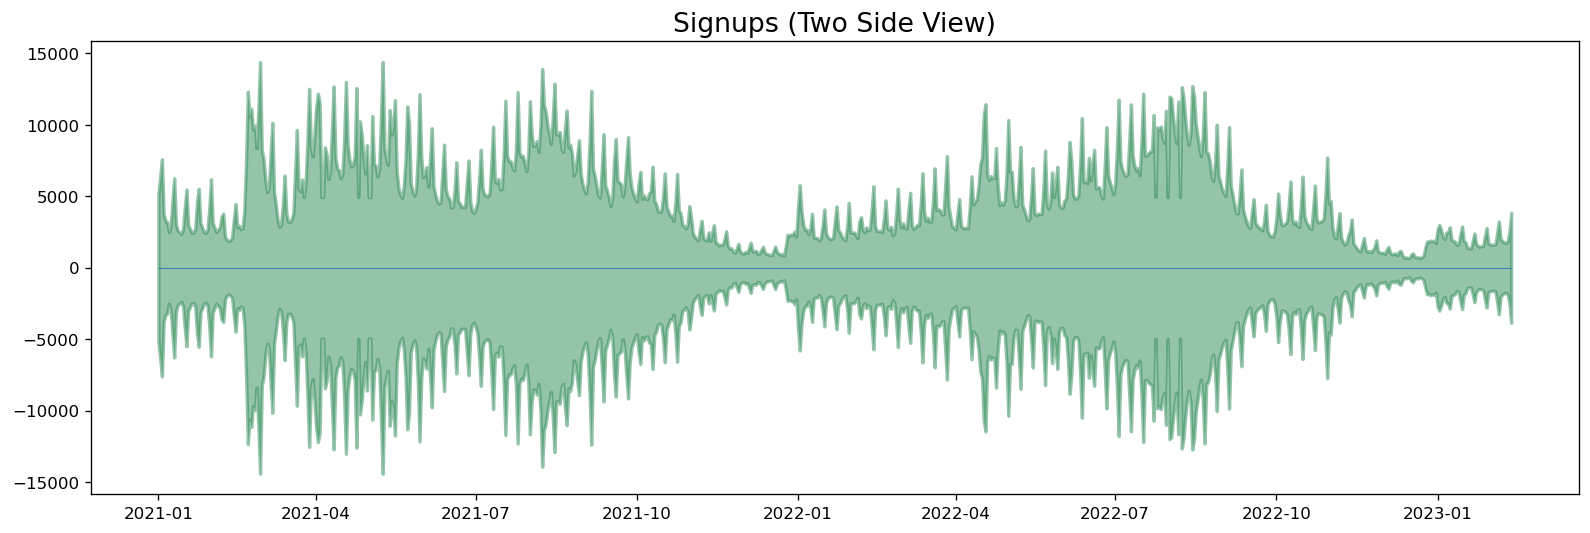

In [9]:
# View on a 2-side graph to examine growth of the metric

x = df['date'].values
y1 = df['signups'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.title('Signups (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df['date']), xmax=np.max(df['date']), linewidth=.5)
plt.show()

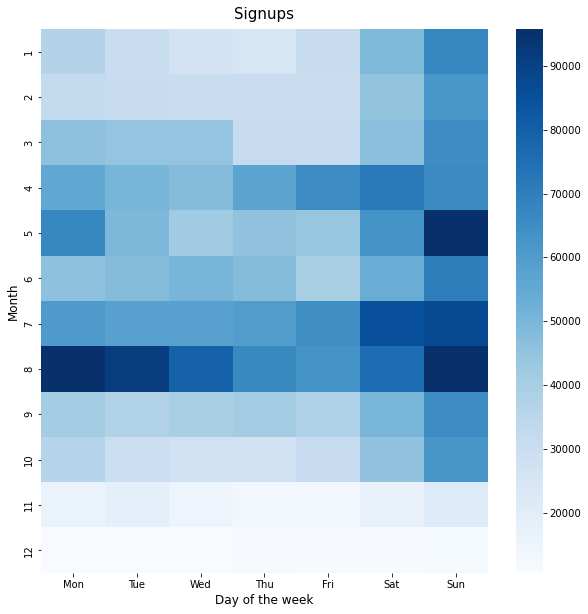

In [12]:
# plot a heatmap based on the seasonal pattern e.g. daily/weekly/monthly

def signups_heatmap(dataframe: pd.DataFrame) -> None:
    """
    This function plots the number of signups by weekday and month
    ---
    Args:
        dataframe (pd.DataFrame): Dataframe that contains the timeseries data

    Returns: None
    """
    # Data
    df = dataframe.copy(deep=False)

    # Reshaping data for the plot
    df["weekday"] = pd.DatetimeIndex(df['date']).weekday
    df["month"] = pd.DatetimeIndex(df['date']).month
    daily_activity = df.groupby(by=['month','weekday']).sum()['signups'].unstack()

    # Figure Object
    fig, ax = plt.subplots(figsize=(10,10), facecolor='w')
    xticklabels = ["Mon", "Tue","Wed", "Thu", "Fri", "Sat", "Sun"]
    sns.heatmap(daily_activity, robust=True, cmap="Blues", xticklabels=xticklabels)

    # Labeling
    ax.set_title("Signups", fontsize=15, pad=10)
    ax.set_xlabel("Day of the week", fontsize=12, x=.5)
    ax.set_ylabel("Month", fontsize=12, y=.5)
    
    plt.show()


signups_heatmap(df)

In [13]:
# Set the date column as the index of the dataframe and the frequency as daily/weekly/monthly
df = df.set_index('date').asfreq('d')

# Depending on the seasonality shown above, you can aggregate the data as required
# E.g. Select the time period and aggregate weekly to avoid weekly trend skewing analysis
df = df['2021-01-01':'2023-02-12'].resample('W').sum()

# Sort the data by the index in ascending order
df = df.sort_index()

In [14]:
#check the start of the dataset
print(df.head())

#check the end of the dataset
print(df.tail())

                   spend  signups
date                             
2021-01-03  19403.215789  19169.0
2021-01-10  27995.051072  26659.0
2021-01-17  23065.880074  22861.0
2021-01-24  23375.869305  23492.0
2021-01-31  23642.839544  23883.0
                   spend  signups
date                             
2023-01-15  15901.824134  14169.0
2023-01-22  11477.280315  12035.0
2023-01-29  11474.462858  12747.0
2023-02-05  13007.963298  13897.0
2023-02-12  14538.671126  15606.0


In [15]:
# Check the index settings are correct including the frequency
print(df.index)

print(df.info())

DatetimeIndex(['2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07',
               ...
               '2022-12-11', '2022-12-18', '2022-12-25', '2023-01-01',
               '2023-01-08', '2023-01-15', '2023-01-22', '2023-01-29',
               '2023-02-05', '2023-02-12'],
              dtype='datetime64[ns]', name='date', length=111, freq='W-SUN')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 111 entries, 2021-01-03 to 2023-02-12
Freq: W-SUN
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   spend    111 non-null    float64
 1   signups  111 non-null    float64
dtypes: float64(2)
memory usage: 2.6 KB
None


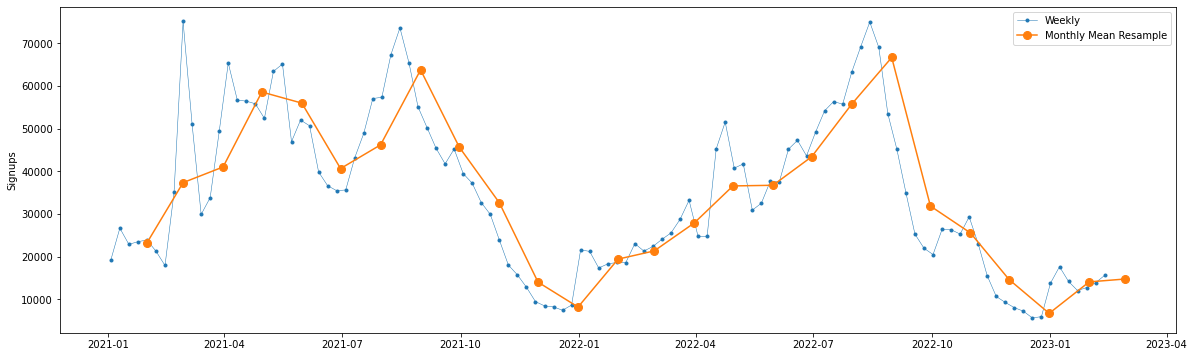

In [16]:
# Visualise the data and check trends including both weekly and monthly view
y = df['signups']

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Signups')
ax.legend();

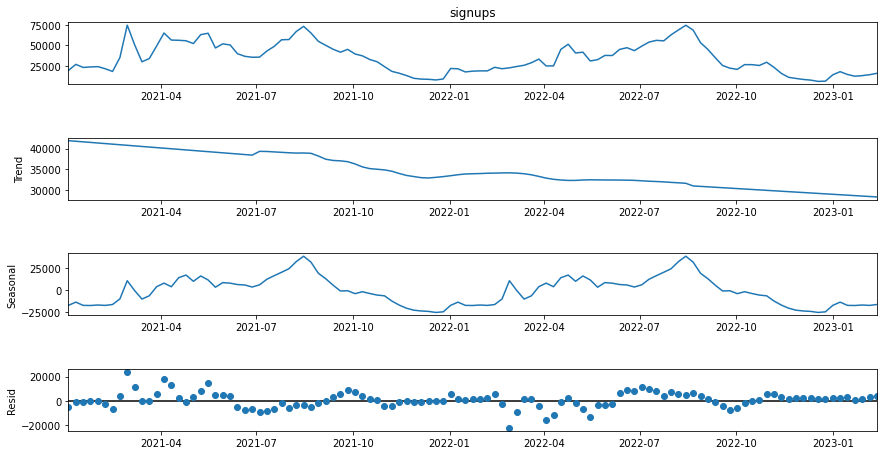

In [17]:
# Graphs to show seasonal_decompose using additive. Check and confirm if any trends remains in residual
def seasonal_decompose_add (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose_add(y)

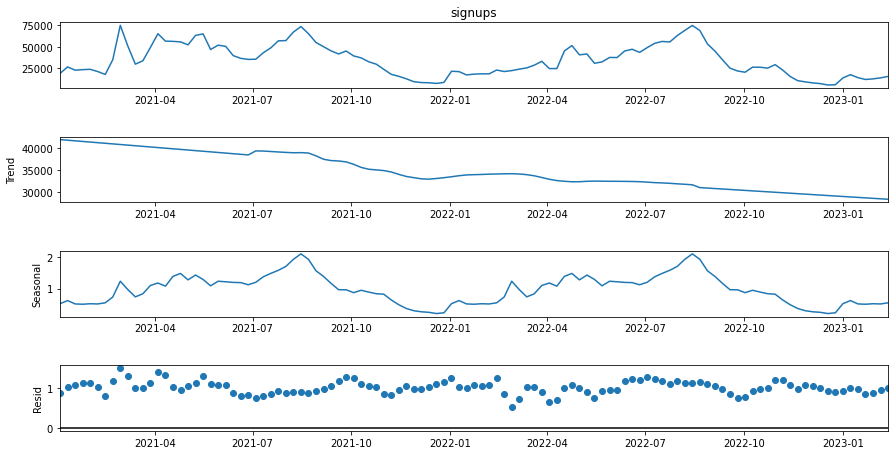

In [18]:
# Graphs to show seasonal_decompose using multiplicative. Check and confirm if any trends remains in residual
def seasonal_decompose_multi (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

seasonal_decompose_multi(y)

/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


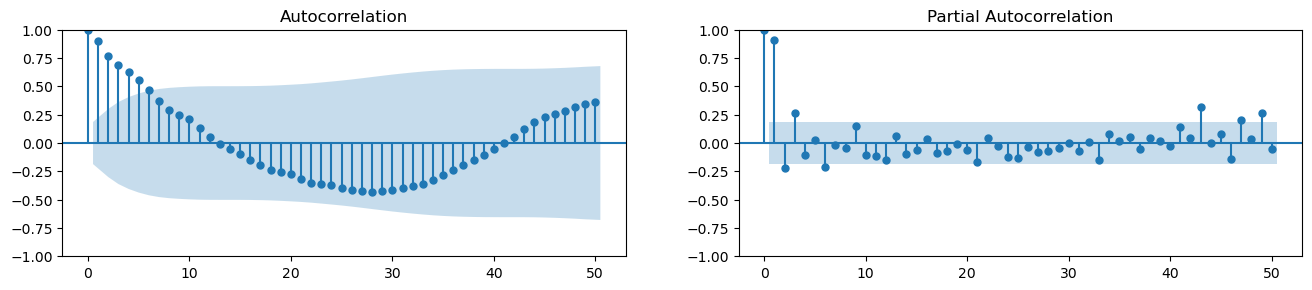

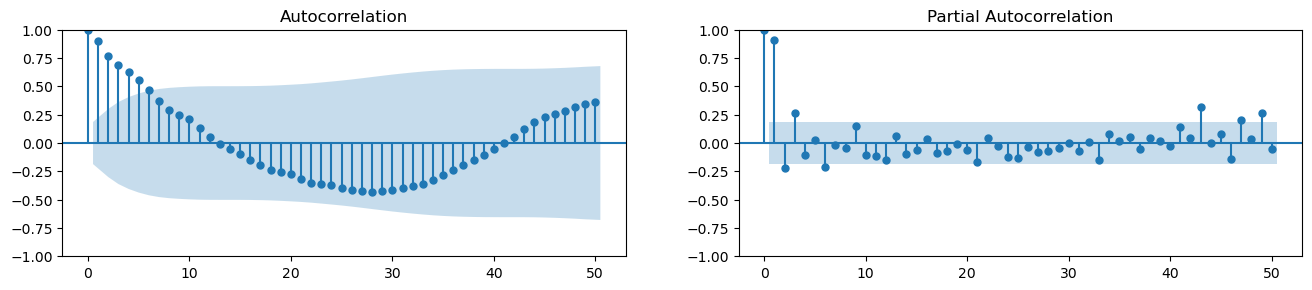

In [19]:
# check for autocorrelation or partial correlation

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['signups'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['signups'].tolist(), lags=50, ax=axes[1])

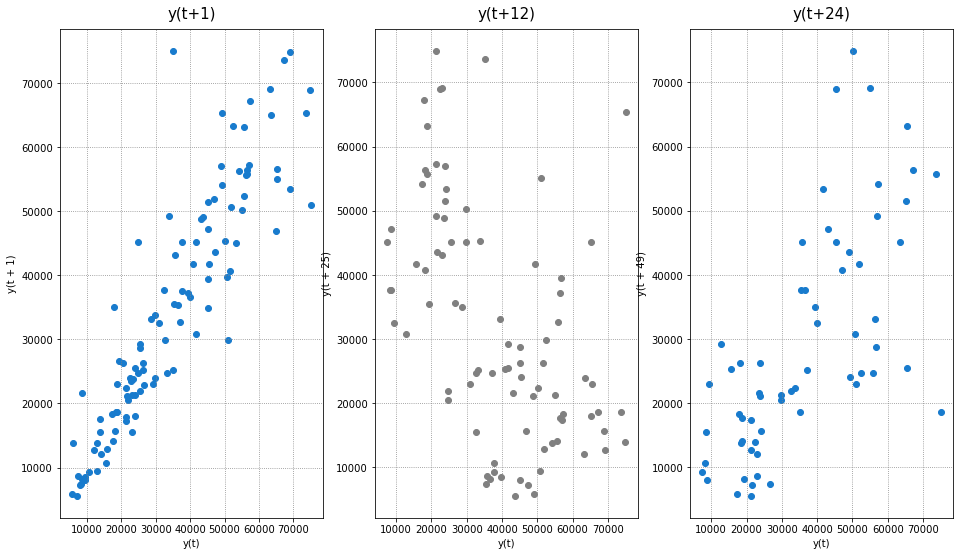

In [20]:
# Lag plot: use this to examine the above lags of interest in more detail 

def lag_plots(df: pd.DataFrame) -> None:
    """
    This function plots the correlation between
    current y(t) and y(t-1), y(t-12) and y(t-24) lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains a time series
        
    Returns: None
    """
    
    # Figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9), facecolor='w')
    
    # Lags
    lag_plot(df['signups'], lag=1, ax=ax1, c='#187bcd')
    lag_plot(df['signups'], lag=25, ax=ax2, c='grey')
    lag_plot(df['signups'], lag=49, ax=ax3, c='#187bcd')
    
    # Labels
    ax1.set_title("y(t+1)", fontsize=15, pad=10)
    ax2.set_title("y(t+12)", fontsize=15, pad=10)
    ax3.set_title("y(t+24)", fontsize=15, pad=10)
    
    # Legend & Grid
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')
    ax3.grid(linestyle=":", color='grey')


lag_plots(df)

In [21]:
### plot for Rolling Statistic for testing whether the data is stationary. 
# This must be completed since are using an ARIMA model for forecasting
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

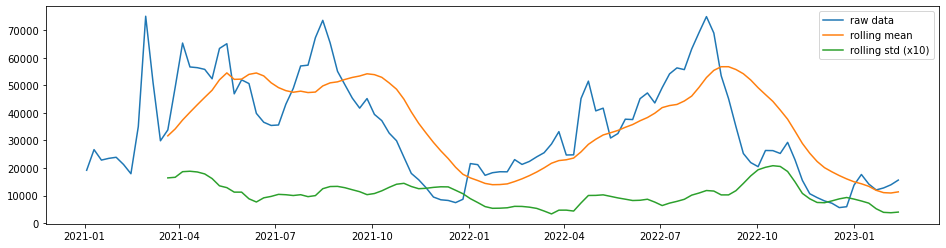

In [22]:
# Rolling statistics results
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

In [23]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [24]:
# Augmented Dickey-Fuller Test Results
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -2.367
P-value = 0.151
Critical values :
	1%: -3.4942202045135513 - The data is not stationary with 99% confidence
	5%: -2.889485291005291 - The data is not stationary with 95% confidence
	10%: -2.5816762131519275 - The data is not stationary with 90% confidence


 > Is the de-trended data stationary ?
Test statistic = -3.332
P-value = 0.014
Critical values :
	1%: -3.5019123847798657 - The data is not stationary with 99% confidence
	5%: -2.892815255482889 - The data is  stationary with 95% confidence
	10%: -2.583453861475781 - The data is  stationary with 90% confidence


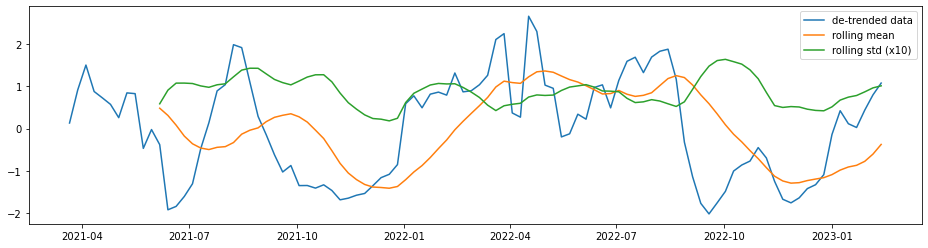

In [25]:
# Detrend the data in order to make stationary using a window which matches the seasonality of the dataset
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the lag differenced data stationary ?
Test statistic = -1.533
P-value = 0.517
Critical values :
	1%: -3.5087828609430614 - The data is not stationary with 99% confidence
	5%: -2.895783561573195 - The data is not stationary with 95% confidence
	10%: -2.5850381719848565 - The data is not stationary with 90% confidence


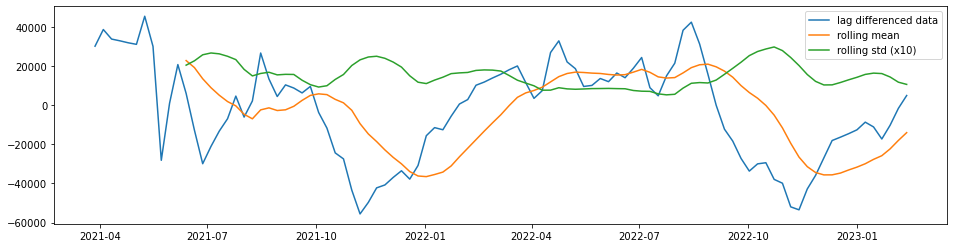

In [26]:
# Differencing using a shift which matches the seasonality of the dataset
y_lag =  y - y.shift(12)

test_stationarity(y_lag,'lag differenced data')
ADF_test(y_lag,'lag differenced data')

 > Is the lag differenced de-trended data stationary ?
Test statistic = -3.212
P-value = 0.019
Critical values :
	1%: -3.512738056978279 - The data is not stationary with 99% confidence
	5%: -2.8974898650628984 - The data is  stationary with 95% confidence
	10%: -2.585948732897085 - The data is  stationary with 90% confidence


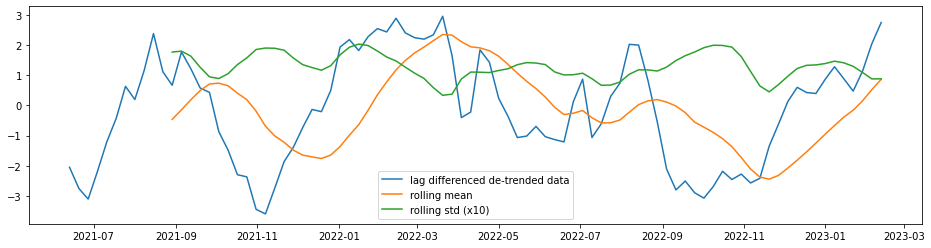

In [27]:
# Detrending + Differencing

y_lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_lag_detrend,'lag differenced de-trended data')
ADF_test(y_lag_detrend,'lag differenced de-trended data')

In [28]:
# Create a training dataset and a validation dataset

y_to_train = y[:'2023-01-30'] # dataset to train
y_to_val = y['2022-11-01':] # last X months for test  
predict_date = len(y) - len(y[:'2022-11-01']) # the number of data points for the test set

In [34]:
#Defining MAPE function
def MAPE(y_actual,y_predicted):
    mape = np.mean(np.abs((y_actual - y_predicted)/y_actual))*100
    return mape

In [30]:
# Complete a sarima grid search to find the right hyperparameters 
# for both the trend and seasonal elements of the series

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [ ]:
# Run the sarima grid search and change the seasonal period to what best fits the dataset

sarima_grid_search(y,52)

In [41]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC

def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))
    
    # Using MAPE error metrics to check for the error rate and accuracy level
    LR_MAPE = MAPE(y,y_forecasted)
    print("MAPE: ",LR_MAPE)

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Signups')
    plt.legend()
    plt.show()
    

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    # Using MAPE error metrics to check for the error rate and accuracy level
    LR_MAPE = MAPE(y,y_forecasted_dynamic)
    print("MAPE: ",LR_MAPE)
    
    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Signups')

    plt.legend()
    plt.show()
    
    return (results)

/Users/thomasgeorgiou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.56760D+00    |proj g|=  3.60535D-01

At iterate    5    f=  5.45082D+00    |proj g|=  3.51754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   2.905D-05   5.451D+00
  F =   5.4508104029690010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

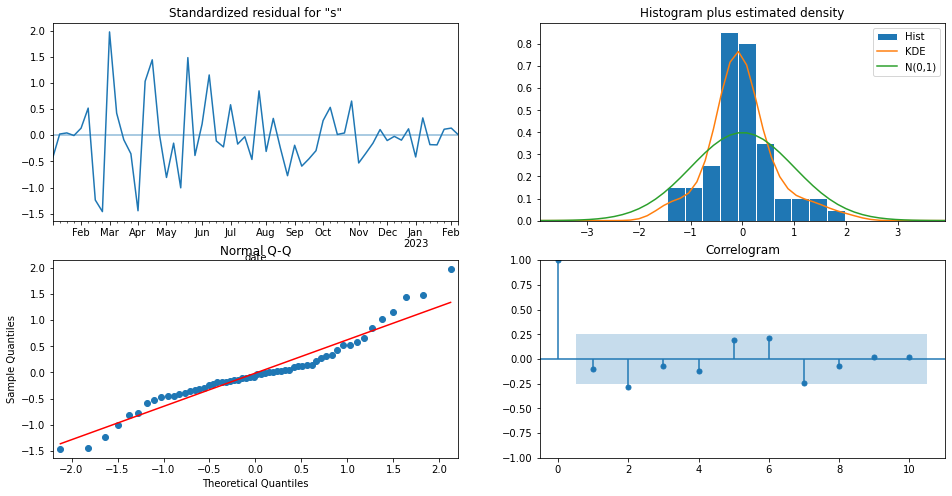

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 2608.6
MAPE:  15.185135263228847


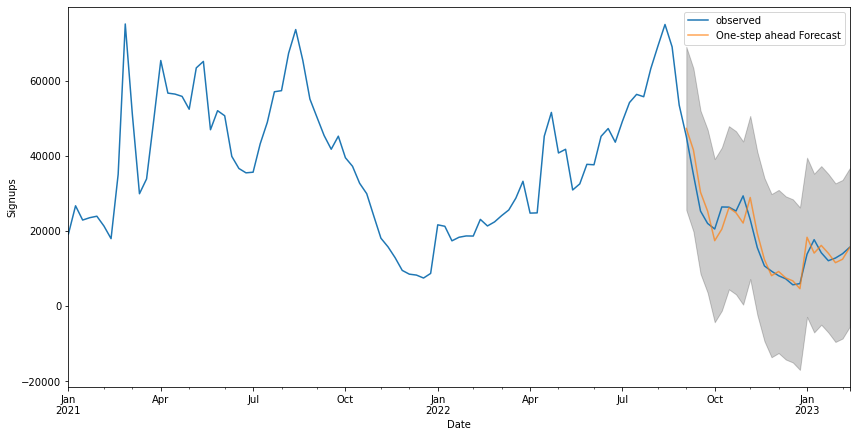

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 17390.78
MAPE:  119.36544785487493


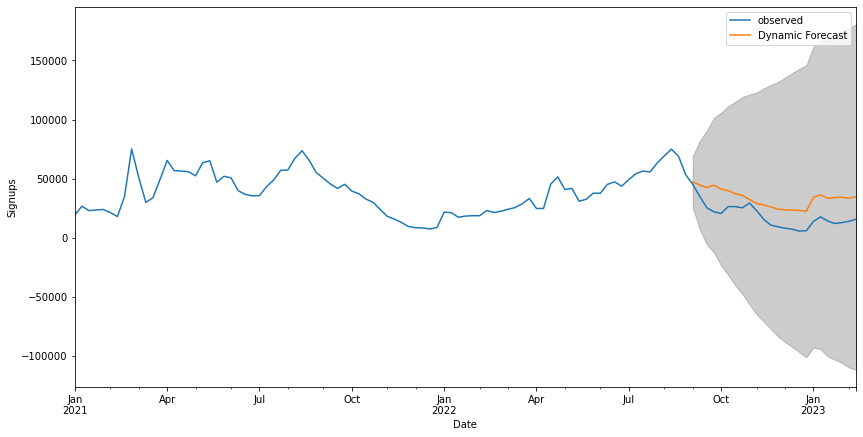

In [42]:
# Update the sarima parameters using the results of the sarima grid search

model = sarima_eva(y,(0, 1, 1),(0, 1, 1,52),52,'2022-09-04',y_to_val)

In [ ]:
# Create the forecast function

def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMA results.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

In [ ]:
# Create the forecast table for the chosen future period

final_table = forecast(model,52,y)
final_table.head()

In [ ]:
# save the final forecasts table as a csv or excel file

final_table.to_csv('final forecast table single variable.csv')
final_table.to_excel('final forecast table single variable excel.xlsx')